## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [2]:
tmp = np.load('../slides/eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [3]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [4]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [5]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.6931, Test Loss: 0.6540
Epoch 2/200, Loss: 0.5752, Test Loss: 0.6151
Epoch 3/200, Loss: 0.4950, Test Loss: 0.5905
Epoch 4/200, Loss: 0.4658, Test Loss: 0.5732
Epoch 5/200, Loss: 0.4261, Test Loss: 0.5496
Epoch 6/200, Loss: 0.4027, Test Loss: 0.5339
Epoch 7/200, Loss: 0.3826, Test Loss: 0.5239
Epoch 8/200, Loss: 0.3678, Test Loss: 0.5216
Epoch 9/200, Loss: 0.3683, Test Loss: 0.5152
Epoch 10/200, Loss: 0.3472, Test Loss: 0.5361
Epoch 11/200, Loss: 0.3466, Test Loss: 0.5374
Epoch 12/200, Loss: 0.3344, Test Loss: 0.5468
Epoch 13/200, Loss: 0.3314, Test Loss: 0.5452
Epoch 14/200, Loss: 0.3362, Test Loss: 0.5402
Epoch 15/200, Loss: 0.3393, Test Loss: 0.5587
Epoch 16/200, Loss: 0.3323, Test Loss: 0.5654
Epoch 17/200, Loss: 0.3308, Test Loss: 0.5596
Epoch 18/200, Loss: 0.3313, Test Loss: 0.5578
Epoch 19/200, Loss: 0.3293, Test Loss: 0.5704
Epoch 20/200, Loss: 0.3314, Test Loss: 0.5732
Epoch 21/200, Loss: 0.3290, Test Loss: 0.5716
Epoch 22/200, Loss: 0.3302, Test Loss: 0.57

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

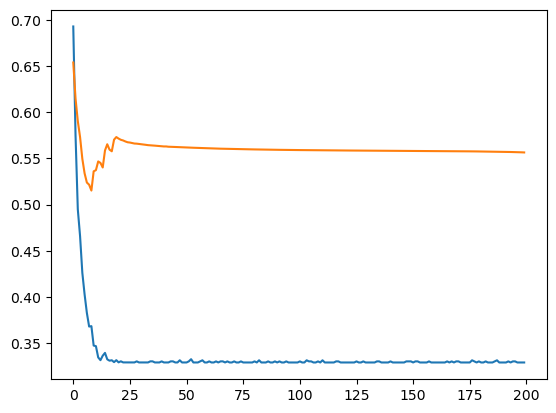

In [7]:
## INSERT CODE HERE
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [8]:
## INSERT CODE HERE
np.min(train_losses), np.min(test_losses)

(0.3288875271876653, 0.5152343610922495)

## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [9]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)  # Dense layer
        self.fc2 = nn.Linear(32, 16)  # Dense layer
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [10]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6805, Test Loss: 0.6695
Epoch 2/200, Loss: 0.5830, Test Loss: 0.6318
Epoch 3/200, Loss: 0.4982, Test Loss: 0.6054
Epoch 4/200, Loss: 0.4791, Test Loss: 0.5699
Epoch 5/200, Loss: 0.4303, Test Loss: 0.5698
Epoch 6/200, Loss: 0.4162, Test Loss: 0.5534
Epoch 7/200, Loss: 0.3930, Test Loss: 0.5503
Epoch 8/200, Loss: 0.3865, Test Loss: 0.5796
Epoch 9/200, Loss: 0.3702, Test Loss: 0.5434
Epoch 10/200, Loss: 0.3614, Test Loss: 0.5487
Epoch 11/200, Loss: 0.3719, Test Loss: 0.5795
Epoch 12/200, Loss: 0.3624, Test Loss: 0.5064
Epoch 13/200, Loss: 0.3488, Test Loss: 0.5582
Epoch 14/200, Loss: 0.3640, Test Loss: 0.5745
Epoch 15/200, Loss: 0.3554, Test Loss: 0.5077
Epoch 16/200, Loss: 0.3470, Test Loss: 0.4998
Epoch 17/200, Loss: 0.3375, Test Loss: 0.5025
Epoch 18/200, Loss: 0.3320, Test Loss: 0.5492
Epoch 19/200, Loss: 0.3359, Test Loss: 0.5221
Epoch 20/200, Loss: 0.3397, Test Loss: 0.5320
Epoch 21/200, Loss: 0.3471, Test Loss: 0.5305
Epoch 22/200, Loss: 0.3390, Test Loss: 0.51

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

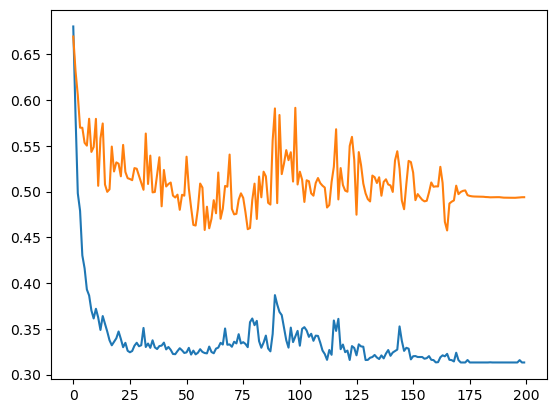

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [12]:
np.min(train_losses), np.min(test_losses)

(0.313261682788531, 0.45753203829129535)

## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [13]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7102, Test Loss: 0.6736
Epoch 2/200, Loss: 0.6923, Test Loss: 0.6612
Epoch 3/200, Loss: 0.6378, Test Loss: 0.6262
Epoch 4/200, Loss: 0.6078, Test Loss: 0.6035
Epoch 5/200, Loss: 0.5567, Test Loss: 0.5986
Epoch 6/200, Loss: 0.5113, Test Loss: 0.5753
Epoch 7/200, Loss: 0.4955, Test Loss: 0.6040
Epoch 8/200, Loss: 0.4530, Test Loss: 0.5774
Epoch 9/200, Loss: 0.4378, Test Loss: 0.5741
Epoch 10/200, Loss: 0.4392, Test Loss: 0.5666
Epoch 11/200, Loss: 0.4158, Test Loss: 0.5264
Epoch 12/200, Loss: 0.4242, Test Loss: 0.6035
Epoch 13/200, Loss: 0.4166, Test Loss: 0.5485
Epoch 14/200, Loss: 0.4051, Test Loss: 0.5567
Epoch 15/200, Loss: 0.3860, Test Loss: 0.5659
Epoch 16/200, Loss: 0.3711, Test Loss: 0.5607
Epoch 17/200, Loss: 0.3768, Test Loss: 0.5885
Epoch 18/200, Loss: 0.3657, Test Loss: 0.5513
Epoch 19/200, Loss: 0.3662, Test Loss: 0.5270
Epoch 20/200, Loss: 0.3673, Test Loss: 0.5409
Epoch 21/200, Loss: 0.3686, Test Loss: 0.5235
Epoch 22/200, Loss: 0.3755, Test Loss: 0.55

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

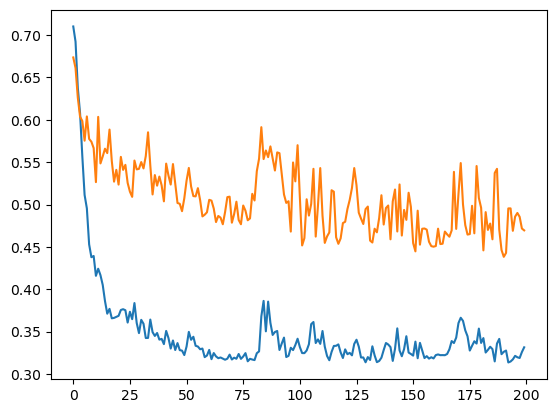

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [15]:
np.min(train_losses), np.min(test_losses)

(0.31353117028872174, 0.4382488528887431)

## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

In [16]:
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7664, Test Loss: 0.6842
Epoch 2/200, Loss: 0.7691, Test Loss: 0.6860
Epoch 3/200, Loss: 0.7412, Test Loss: 0.6938
Epoch 4/200, Loss: 0.7559, Test Loss: 0.6868
Epoch 5/200, Loss: 0.7441, Test Loss: 0.6788
Epoch 6/200, Loss: 0.7076, Test Loss: 0.6554
Epoch 7/200, Loss: 0.7499, Test Loss: 0.6659
Epoch 8/200, Loss: 0.7060, Test Loss: 0.6788
Epoch 9/200, Loss: 0.6839, Test Loss: 0.6615
Epoch 10/200, Loss: 0.6530, Test Loss: 0.6560
Epoch 11/200, Loss: 0.6621, Test Loss: 0.6738
Epoch 12/200, Loss: 0.6494, Test Loss: 0.6672
Epoch 13/200, Loss: 0.6367, Test Loss: 0.6359
Epoch 14/200, Loss: 0.6157, Test Loss: 0.6364
Epoch 15/200, Loss: 0.6025, Test Loss: 0.6311
Epoch 16/200, Loss: 0.6012, Test Loss: 0.6301
Epoch 17/200, Loss: 0.6079, Test Loss: 0.6070
Epoch 18/200, Loss: 0.5887, Test Loss: 0.6146
Epoch 19/200, Loss: 0.5572, Test Loss: 0.6084
Epoch 20/200, Loss: 0.5721, Test Loss: 0.6047
Epoch 21/200, Loss: 0.5525, Test Loss: 0.5992
Epoch 22/200, Loss: 0.5389, Test Loss: 0.60

In [17]:
np.min(train_losses), np.min(test_losses)

(0.33951646089553833, 0.42452441652615863)

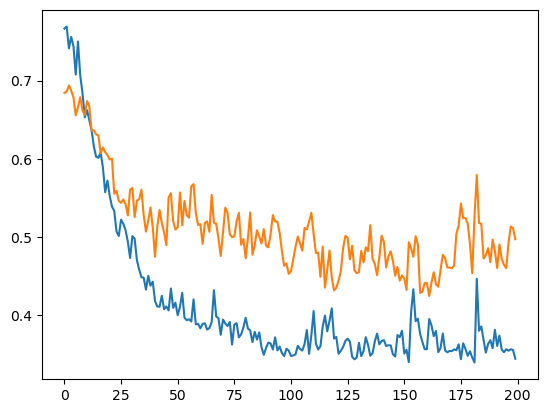

In [18]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')